# Functions

Welcome to lab 4! This week, we'll focus on functions and the table method `apply` from [Section 8.1](https://umass-data-science.github.io/190fwebsite/textbook/08/1/applying-a-function-to-a-column/).


In [1]:
import numpy as np
from datascience import *

# These lines set up graphing capabilities.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


## 1. Functions and CEO Incomes

Let's start with a real data analysis task.  We'll look at the 2015 compensation of CEOs at the 100 largest companies in California.  The data were compiled for a Los Angeles Times analysis [here](http://spreadsheets.latimes.com/california-ceo-compensation/), and ultimately came from [filings](https://www.sec.gov/answers/proxyhtf.htm) mandated by the SEC from all publicly-traded companies.  Two companies have two CEOs, so there are 102 CEOs in the dataset.

We've copied the data in raw form from the LA Times page into a file called `raw_compensation.csv`.  (The page notes that all dollar amounts are in millions of dollars.)

In [2]:
raw_compensation = Table.read_table('raw_compensation.csv')
raw_compensation

Rank,Name,Company (Headquarters),Total Pay,% Change,Cash Pay,Equity Pay,Other Pay,Ratio of CEO pay to average industry worker pay
1,Mark V. Hurd*,Oracle (Redwood City),$53.25,(No previous year),$0.95,$52.27,$0.02,362
2,Safra A. Catz*,Oracle (Redwood City),$53.24,(No previous year),$0.95,$52.27,$0.02,362
3,Robert A. Iger,Walt Disney (Burbank),$44.91,-3%,$24.89,$17.28,$2.74,477
4,Marissa A. Mayer,Yahoo! (Sunnyvale),$35.98,-15%,$1.00,$34.43,$0.55,342
5,Marc Benioff,salesforce.com (San Francisco),$33.36,-16%,$4.65,$27.26,$1.45,338
6,John H. Hammergren,McKesson (San Francisco),$24.84,-4%,$12.10,$12.37,$0.37,222
7,John S. Watson,Chevron (San Ramon),$22.04,-15%,$4.31,$14.68,$3.05,183
8,Jeffrey Weiner,LinkedIn (Mountain View),$19.86,27%,$2.47,$17.26,$0.13,182
9,John T. Chambers**,Cisco Systems (San Jose),$19.62,19%,$5.10,$14.51,$0.01,170
10,John G. Stumpf,Wells Fargo (San Francisco),$19.32,-10%,$6.80,$12.50,$0.02,256


**Question 1.** We want to compute the average of the CEOs' pay. Try running the cell below.

In [3]:
np.average(raw_compensation.column("Total Pay"))

TypeError: cannot perform reduce with flexible type

You should see an error. Let's examine why this error occured by looking at the values in the "Total Pay" column. Use the `type` function and set `total_pay_type` to the type of the first value in the "Total Pay" column.

In [5]:
total_pay_type = type(raw_compensation.column('Total Pay')[0])
total_pay_type

numpy.str_

**Question 2.** You should have found that the values in "Total Pay" column are strings (text). It doesn't make sense to take the average of the text values, so we need to convert them to numbers if we want to do this. Extract the first value in the "Total Pay" column.  It's Mark Hurd's pay in 2015, in *millions* of dollars.  Call it `mark_hurd_pay_string`.

In [6]:
mark_hurd_pay_string = raw_compensation.column('Total Pay')[0]
mark_hurd_pay_string

'$53.25 '

**Question 3.** Convert `mark_hurd_pay_string` to a number of *dollars*.  The string method `strip` will be useful for removing the dollar sign; it removes a specified character from the start or end of a string.  For example, the value of `"100%".strip("%")` is the string `"100"`.  You'll also need the function `float`, which converts a string that looks like a number to an actual number.  Last, remember that the answer should be in dollars, not millions of dollars.

In [26]:
mark_hurd_pay = float(mark_hurd_pay_string.strip("$"))*1000000
mark_hurd_pay

53250000.0

To compute the average pay, we need to do this for every CEO.  But that looks like it would involve copying this code 102 times.

This is where functions come in.  First, we'll define a new function, giving a name to the expression that converts "total pay" strings to numeric values.  Later in this lab we'll see the payoff: we can call that function on every pay string in the dataset at once.

**Question 4.** Copy the expression you used to compute `mark_hurd_pay` as the `return` expression of the function below, but replace the specific `mark_hurd_pay_string` with the generic `pay_string` name specified in the first line of the `def` statement.

*Hint*: When dealing with functions, you should generally not be referencing any variable outside of the function. Usually, you want to be working with the arguments that are passed into it, such as `pay_string` for this function. 

In [27]:
def convert_pay_string_to_number(pay_string):
    """Converts a pay string like '$100' (in millions) to a number of dollars."""    
    return float(pay_string.strip("$"))

Running that cell doesn't convert any particular pay string. Instead, it creates a function called `convert_pay_string_to_number` that can convert any string with the right format to a number representing millions of dollars.

We can call our function just like we call the built-in functions we've seen. It takes one argument, a string, and it returns a number.

In [28]:
convert_pay_string_to_number('$42')

42.0

In [29]:
convert_pay_string_to_number(mark_hurd_pay_string)

53.25

In [30]:
# We can also compute Safra Catz's pay in the same way:
convert_pay_string_to_number(raw_compensation.where("Name", are.containing("Safra")).column("Total Pay").item(0))

53.24

So, what have we gained by defining the `convert_pay_string_to_number` function? 
Well, without it, we'd have to copy that `10**6 * float(pay_string.strip("$"))` stuff each time we wanted to convert a pay string.  Now we just call a function whose name says exactly what it's doing.

Soon, we'll see how to apply this function to every pay string in a single expression. First, let's take a brief detour and introduce `interact`.

### Using `interact`

We've included a nifty function called `interact` that allows you to
call a function with different arguments.

To use it, call `interact` with the function you want to interact with as the
first argument, then specify a default value for each argument of the original
function like so:

In [31]:
_ = interact(convert_pay_string_to_number, pay_string='$42')

interactive(children=(Text(value='$42', description='pay_string'), Output()), _dom_classes=('widget-interact',…

You can now change the value in the textbox to automatically call
`convert_pay_string_to_number` with the argument you enter in the `pay_string`
textbox. For example, entering in `'$49'` in the textbox will display the result of
running `convert_pay_string_to_number('$49')`. Neat!

Note that we'll never ask you to write the `interact` function calls yourself as
part of a question. However, we'll include it here and there where it's helpful
and you'll probably find it useful to use yourself.

Now, let's continue on and write more functions.

## 2. Defining functions

Let's write a very simple function that converts a proportion to a percentage by multiplying it by 100.  For example, the value of `to_percentage(.5)` should be the number 50.  (No percent sign.)

A function definition has a few parts.

##### `def`
It always starts with `def` (short for **def**ine):

    def

##### Name
Next comes the name of the function.  Let's call our function `to_percentage`.
    
    def to_percentage

##### Signature
Next comes something called the *signature* of the function.  This tells Python how many arguments your function should have, and what names you'll use to refer to those arguments in the function's code.  `to_percentage` should take one argument, and we'll call that argument `proportion` since it should be a proportion.

    def to_percentage(proportion)

We put a colon after the signature to tell Python it's over.

    def to_percentage(proportion):

##### Documentation
Functions can do complicated things, so you should write an explanation of what your function does.  For small functions, this is less important, but it's a good habit to learn from the start.  Conventionally, Python functions are documented by writing a triple-quoted string:

    def to_percentage(proportion):
        """Converts a proportion to a percentage."""
    
    
##### Body
Now we start writing code that runs when the function is called.  This is called the *body* of the function.  We can write anything we could write anywhere else.  First let's give a name to the number we multiply a proportion by to get a percentage.

    def to_percentage(proportion):
        """Converts a proportion to a percentage."""
        factor = 100

##### `return`
The special instruction `return` in a function's body tells Python to make the value of the function call equal to whatever comes right after `return`.  We want the value of `to_percentage(.5)` to be the proportion .5 times the factor 100, so we write:

    def to_percentage(proportion):
        """Converts a proportion to a percentage."""
        factor = 100
        return proportion * factor
Note that `return` inside a function gives the function a value, while `print`, which we have used before, is a function which has no `return` value and just prints a certain value out to the console. The two are very different. 

**Question 1.** Define `to_percentage` in the cell below.  Call your function to convert the proportion .2 to a percentage.  Name that percentage `twenty_percent`.

In [ ]:
def to_percentage(.5)
    """ ... """
    ... = ...
    return ...

twenty_percent = ...
twenty_percent


Like the built-in functions, you can use named values as arguments to your function.

**Question 2.** Use `to_percentage` again to convert the proportion named `a_proportion` (defined below) to a percentage called `a_percentage`.

*Note:* You don't need to define `to_percentage` again!  Just like other named things, functions stick around after you define them.

In [33]:
a_proportion = 2**(.5) / 2
a_percentage = to_percentage(a_proportion)
a_percentage


70.71067811865476

Here's something important about functions: the names assigned within a function body are only accessible within the function body. Once the function has returned, those names are gone.  So even though you defined `factor = 100` inside `to_percentage` above and then called `to_percentage`, you cannot refer to `factor` anywhere except inside the body of `to_percentage`:

In [ ]:
# You should see an error when you run this.  (If you don't, you might
# have defined factor somewhere above.)
factor

As we've seen with the built-in functions, functions can also take strings (or arrays, or tables) as arguments, and they can return those things, too.

**Question 3.** Define a function called `disemvowel`.  It should take a single string as its argument.  (You can call that argument whatever you want.)  It should return a copy of that string, but with all the characters that are vowels removed.  (In English, the vowels are the characters "a", "e", "i", "o", and "u".)

*Hint 1:* To remove all the "a"s from a string, you can use `that_string.replace("a", "")`.  The `.replace` method for strings returns another string, so you can call `replace` multiple times, one after the other. 

*Hint 2:* You can write code for each vowel, but think about how you could solve the problem with  less code using a for loop.

In [74]:
def disemvowel(a_string):
    vowels = ["a", "e", "i", "o","u"]
    vowels = vowels + [x.upper() for x in vowels]
    for vowel in vowels:
        a_string = a_string.replace(vowel, "")
    return a_string


# An example call to your function.  (It's often helpful to run
# an example call from time to time while you're writing a function,
# to see how it currently works.)
disemvowel("Can you read this without vowels?")

'Cn y rd ths wtht vwls?'

In [46]:
# Alternatively, you can use interact to call your function
_ = interact(disemvowel, a_string='Hello world')

interactive(children=(Text(value='Hello world', description='a_string'), Output()), _dom_classes=('widget-inte…

##### Calls on calls on calls
Just as you write a series of lines to build up a complex computation, it's useful to define a series of small functions that build on each other.  Since you can write any code inside a function's body, you can call other functions you've written.

If a function is a like a recipe, defining a function in terms of other functions is like having a recipe for cake telling you to follow another recipe to make the frosting, and another to make the sprinkles.  This makes the cake recipe shorter and clearer, and it avoids having a bunch of duplicated frosting recipes.  It's a foundation of productive programming.

For example, suppose you want to count the number of characters *that aren't vowels* in a piece of text.  One way to do that is this to remove all the vowels and count the size of the remaining string.

**Question 4.** Write a function called `num_non_vowels`.  It should take a string as its argument and return a number.  The number should be the number of characters in the argument string that aren't vowels.

*Hint:* The function `len` takes a string as its argument and returns the number of characters in it.

In [76]:
def num_non_vowels(a_string):
    """The number of characters in a string, minus the vowels."""
    return len(disemvowel(a_string))
    
num_non_vowels("t e t")
# Try calling your function yourself to make sure the output is what
# you expect. You can also use the interact function if you'd like.

4

Functions can also encapsulate code that *does things* rather than just computing values.  For example, if you call `print` inside a function, and then call that function, something will get printed.

The `movies_by_year` dataset in the textbook has information about movie sales in recent years.  Suppose you'd like to display the year with the 5th-highest total gross movie sales, printed in a human-readable way.  You might do this:

In [77]:
movies_by_year = Table.read_table("movies_by_year.csv")
rank = 5
fifth_from_top_movie_year = movies_by_year.sort("Total Gross", descending=True).column("Year").item(rank-1)
print("Year number", rank, "for total gross movie sales was:", fifth_from_top_movie_year)

Year number 5 for total gross movie sales was: 2010


After writing this, you realize you also wanted to print out the 2nd and 3rd-highest years.  Instead of copying your code, you decide to put it in a function.  Since the rank varies, you make that an argument to your function.

**Question 5.** Write a function called `print_kth_top_movie_year`.  It should take a single argument, the rank of the year (like 2, 3, or 5 in the above examples).  It should print out a message like the one above.  It shouldn't have a `return` statement.

In [81]:
def print_kth_top_movie_year(k):
    # Our solution used 2 lines.
    nth_from_top_movie_year = movies_by_year.sort("Total Gross", descending=True).column("Year").item(k-1)
    print("Year number", k, "for total gross movie sales was:", nth_from_top_movie_year) 


# Example calls to your function:
print_kth_top_movie_year(2)
print_kth_top_movie_year(3)

Year number 2 for total gross movie sales was: 2013
Year number 3 for total gross movie sales was: 2012


In [ ]:
# interact also allows you to pass in an array for a function argument. It will
# then present a dropdown menu of options.
_ = interact(print_kth_top_movie_year, k=np.arange(1, 10))

## 3. `apply`ing functions

Defining a function is a lot like giving a name to a value with `=`.  In fact, a function is a value just like the number 1 or the text "the"!

For example, we can make a new name for the built-in function `max` if we want:

In [ ]:
our_name_for_max = max
our_name_for_max(2, 6)

The old name for `max` is still around:

In [ ]:
max(2, 6)

Try just writing `max` or `our_name_for_max` (or the name of any other function) in a cell, and run that cell.  Python will print out a (very brief) description of the function.

In [82]:
max

<function max>

Why is this useful?  Since functions are just values, it's possible to pass them as arguments to other functions.  Here's a simple but not-so-practical example: we can make an array of functions.

In [83]:
make_array(max, np.average, are.equal_to)

array([<built-in function max>, <function average at 0x7ffc30908430>,
       <function are.equal_to at 0x7ffc407d4940>], dtype=object)

**Question 1.** Make an array containing any 3 other functions you've seen.  Call it `some_functions`.

In [106]:
some_functions = [max, min]
some_functions
[x(1,2,3) for x in some_functions]

[3, 1]

Working with functions as values can lead to some funny-looking code.  For example, see if you can figure out why this works:

In [95]:
make_array(max, np.average, are.equal_to).item(0)(4, -2, 7)

7

Here's a simpler example that's actually useful: the table method `apply`.

`apply` calls a function many times, once on *each* element in a column of a table.  It produces an array of the results.  Here we use `apply` to convert every CEO's pay to a number, using the function you defined:

In [107]:
raw_compensation.apply(convert_pay_string_to_number, "Total Pay")

array([5.325e+01, 5.324e+01, 4.491e+01, 3.598e+01, 3.336e+01, 2.484e+01,
       2.204e+01, 1.986e+01, 1.962e+01, 1.932e+01, 1.876e+01, 1.861e+01,
       1.836e+01, 1.809e+01, 1.710e+01, 1.663e+01, 1.633e+01, 1.614e+01,
       1.610e+01, 1.602e+01, 1.510e+01, 1.498e+01, 1.463e+01, 1.451e+01,
       1.444e+01, 1.436e+01, 1.431e+01, 1.409e+01, 1.400e+01, 1.367e+01,
       1.234e+01, 1.220e+01, 1.218e+01, 1.213e+01, 1.205e+01, 1.184e+01,
       1.171e+01, 1.163e+01, 1.116e+01, 1.111e+01, 1.111e+01, 1.073e+01,
       1.050e+01, 1.043e+01, 1.037e+01, 1.028e+01, 1.027e+01, 1.018e+01,
       1.016e+01, 9.970e+00, 9.960e+00, 9.860e+00, 9.740e+00, 9.420e+00,
       9.390e+00, 9.220e+00, 9.060e+00, 9.030e+00, 8.860e+00, 8.760e+00,
       8.570e+00, 8.380e+00, 8.360e+00, 8.350e+00, 8.230e+00, 7.860e+00,
       7.700e+00, 7.580e+00, 7.510e+00, 7.230e+00, 7.210e+00, 7.120e+00,
       6.880e+00, 6.770e+00, 6.640e+00, 6.560e+00, 6.140e+00, 5.920e+00,
       5.900e+00, 5.890e+00, 5.730e+00, 5.420e+00, 

Here's an illustration of what that did:

<img src="apply.png"/>

Note that we didn't write something like `convert_pay_string_to_number()` or `convert_pay_string_to_number("Total Pay")`.  The job of `apply` is to call the function we give it, so instead of calling `convert_pay_string_to_number` ourselves, we just write its name as an argument to `apply`.

**Question 2.** Using `apply`, make a table that's a copy of `raw_compensation` with one more column called "Total Pay (\$)".  It should be the result of applying `convert_pay_string_to_number` to the "Total Pay" column, as we did above, and creating a new table which is the old one, but with the "Total Pay" column redone.  Call the new table `compensation`.

In [109]:
compensation = raw_compensation.with_column(
    "Total Pay ($)",
    raw_compensation.apply(convert_pay_string_to_number, "Total Pay"))
compensation


Rank,Name,Company (Headquarters),Total Pay,% Change,Cash Pay,Equity Pay,Other Pay,Ratio of CEO pay to average industry worker pay,Total Pay ($)
1,Mark V. Hurd*,Oracle (Redwood City),$53.25,(No previous year),$0.95,$52.27,$0.02,362,53.25
2,Safra A. Catz*,Oracle (Redwood City),$53.24,(No previous year),$0.95,$52.27,$0.02,362,53.24
3,Robert A. Iger,Walt Disney (Burbank),$44.91,-3%,$24.89,$17.28,$2.74,477,44.91
4,Marissa A. Mayer,Yahoo! (Sunnyvale),$35.98,-15%,$1.00,$34.43,$0.55,342,35.98
5,Marc Benioff,salesforce.com (San Francisco),$33.36,-16%,$4.65,$27.26,$1.45,338,33.36
6,John H. Hammergren,McKesson (San Francisco),$24.84,-4%,$12.10,$12.37,$0.37,222,24.84
7,John S. Watson,Chevron (San Ramon),$22.04,-15%,$4.31,$14.68,$3.05,183,22.04
8,Jeffrey Weiner,LinkedIn (Mountain View),$19.86,27%,$2.47,$17.26,$0.13,182,19.86
9,John T. Chambers**,Cisco Systems (San Jose),$19.62,19%,$5.10,$14.51,$0.01,170,19.62
10,John G. Stumpf,Wells Fargo (San Francisco),$19.32,-10%,$6.80,$12.50,$0.02,256,19.32


Now that we have the pay in numbers, we can compute things about them.

**Question 3.** Compute the average total pay of the CEOs in the dataset.

In [119]:
average_total_pay = np.average(compensation.column("Total Pay ($)"))
average_total_pay



11.445294117647055

**Question 4.** Companies pay executives in a variety of ways: directly in cash; by granting stock or other "equity" in the company; or with ancillary benefits (like private jets).  Compute the proportion of each CEO's pay that was cash.  (Your answer should be an array of numbers, one for each CEO in the dataset.)

In [121]:
cash_proportion = compensation.apply(convert_pay_string_to_number, "Cash Pay")
cash_proportion



array([ 0.95,  0.95, 24.89,  1.  ,  4.65, 12.1 ,  4.31,  2.47,  5.1 ,
        6.8 ,  5.77,  4.12,  2.41,  3.09,  3.95,  1.12,  2.13,  4.52,
        5.35,  2.46,  4.43,  3.27,  4.55,  3.64,  3.32,  2.44,  4.55,
        3.69,  3.97,  2.14,  4.71,  3.53,  2.48,  5.78,  5.5 ,  4.31,
        2.55,  2.88,  4.75,  2.9 ,  2.04,  1.55,  3.5 ,  1.13,  2.17,
       10.  ,  2.36,  2.32,  3.85,  2.51,  7.36,  3.65,  2.35,  2.01,
        1.93,  2.15,  3.05,  3.5 ,  4.97,  1.03,  3.02,  2.05,  2.09,
        1.98,  3.57,  2.47,  3.57,  2.47,  1.86,  7.14,  1.96,  6.85,
        2.19,  5.55,  1.58,  1.15,  1.3 ,  2.2 ,  1.61,  1.59,  3.16,
        1.95,  0.  ,  2.32,  2.32,  1.33,  0.69,  1.98,  1.84,  1.21,
        2.85,  1.73,  1.89,  1.85,  0.91,  1.66,  1.5 ,  0.93,  0.71,
        0.  ,  0.04,  0.  ])

Check out the "% Change" column in `compensation`.  It shows the percentage increase in the CEO's pay from the previous year.  For CEOs with no previous year on record, it instead says "(No previous year)".  The values in this column are *strings*, not numbers, so like the "Total Pay" column, it's not usable without a bit of extra work.

Given your current pay and the percentage increase from the previous year, you can compute your previous year's pay.  For example, if your pay is \$100 this year, and that's an increase of 50% from the previous year, then your previous year's pay was $\frac{\$100}{1 + \frac{50}{100}}$, or around \$66.66.

**Question 5.** Create a new table called `with_previous_compensation`.  It should be a copy of `compensation`, but with the "(No previous year)" CEOs filtered out, and with an extra column called "2014 Total Pay ($)".  That column should have each CEO's pay in 2014.

*Hint:* This question takes several steps, but each one is still something you've seen before.  Take it one step at a time, using as many lines as you need.  You can print out your results after each step to make sure you're on the right track.

*Hint 2:* You'll need to define a function.  You can do that just above your other code.

In [137]:
#For reference, our solution involved more than just this one line of code
def to_percent(s):
    return float(s.strip("%"))/100.0

filtered = compensation.where("% Change", are.not_containing("(No previous year)"))

with_previous_compensation = filtered.with_column(
    "2014 Total Pay ($)", 
     filtered.column("Total Pay ($)")/(1+filtered.apply(to_percent, "% Change"))
    )

with_previous_compensation

Rank,Name,Company (Headquarters),Total Pay,% Change,Cash Pay,Equity Pay,Other Pay,Ratio of CEO pay to average industry worker pay,Total Pay ($),2014 Total Pay ($)
3,Robert A. Iger,Walt Disney (Burbank),$44.91,-3%,$24.89,$17.28,$2.74,477,44.91,46.299
4,Marissa A. Mayer,Yahoo! (Sunnyvale),$35.98,-15%,$1.00,$34.43,$0.55,342,35.98,42.3294
5,Marc Benioff,salesforce.com (San Francisco),$33.36,-16%,$4.65,$27.26,$1.45,338,33.36,39.7143
6,John H. Hammergren,McKesson (San Francisco),$24.84,-4%,$12.10,$12.37,$0.37,222,24.84,25.875
7,John S. Watson,Chevron (San Ramon),$22.04,-15%,$4.31,$14.68,$3.05,183,22.04,25.9294
8,Jeffrey Weiner,LinkedIn (Mountain View),$19.86,27%,$2.47,$17.26,$0.13,182,19.86,15.6378
9,John T. Chambers**,Cisco Systems (San Jose),$19.62,19%,$5.10,$14.51,$0.01,170,19.62,16.4874
10,John G. Stumpf,Wells Fargo (San Francisco),$19.32,-10%,$6.80,$12.50,$0.02,256,19.32,21.4667
11,John C. Martin**,Gilead Sciences (Foster City),$18.76,-1%,$5.77,$12.98,$0.01,117,18.76,18.9495
13,Shantanu Narayen,Adobe Systems (San Jose),$18.36,3%,$2.41,$15.85,$0.09,125,18.36,17.8252


**Question 6.** What was the average pay of these CEOs in 2014?

In [ ]:
average_pay_2014 = ...
average_pay_2014

## 4. Histograms
Earlier, we computed the average pay among the CEOs in our 102-CEO dataset.  The average doesn't tell us everything about the amounts CEOs are paid, though.  Maybe just a few CEOs make the bulk of the money, even among these 102.

We can use a *histogram* to display more information about a set of numbers.  The table method `hist` takes a single argument, the name of a column of numbers.  It produces a histogram of the numbers in that column.

**Question 1.** Make a histogram of the pay of the CEOs in `compensation`.

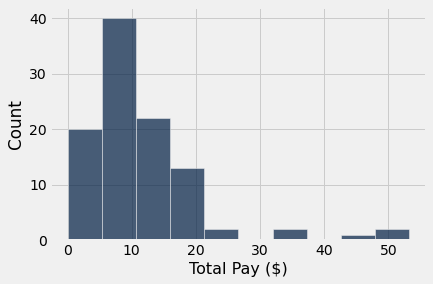

In [136]:
compensation.hist("Total Pay ($)", normed = False)

**Question 2.** Looking at the histogram, how many CEOs made more than \$30 million?  (Answer the question by filling in your answer manually.  You'll have to do a bit of arithmetic; feel free to use Python as a calculator.)

In [ ]:
num_ceos_more_than_30_million =...


**Question 3.** Answer the same question with code.  *Hint:* Use the table method `where` and the property `num_rows`.

In [ ]:
num_ceos_more_than_30_million_2 = ...
num_ceos_more_than_30_million_2



Great job! :D You're finished with lab 4! Be sure to...

- Select **Save and Checkpoint** from the `File` menu,
- **Download** your notebook (.ipynb) and PDF from the `File` menu,
- Upload your notebook (.ipynb) to [Gradescope](https://www.gradescope.com/courses/84122) and your PDF to Moodl
- And ask the TA to check you off.